# Modules Import

In [1]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as G
from torch.utils.data import DataLoader,Dataset, random_split
from glob import glob
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Data Pre Processing

In [3]:
class GaussianNoise:
    def __init__(self, std=0.03):
        self.std = std

    def __call__(self, tensor):
        if self.std == 0:
            return tensor
            # randn samples from normal distribution(mu=0 , std=1)
        return tensor + torch.randn(tensor.size()) * self.std

transforms_train_img=T.Compose([
    T.Resize((256,256)),
    T.ToTensor(), # converts to [0,1] 
    # T.RandomHorizontalFlip(p=.5),
    # T.RandomVerticalFlip(p=.5), # commented out to prevent random flip of image and mask
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # T.RandomRotation(15),
    T.Normalize(mean=[.5]*3,std=[.5]*3), # (mean, Var); Is specified ! As we normalize images according to mean, var from image net dist...lot of imgs are from there
    #mostly trained on imagenet.
    GaussianNoise(std=.015)
])

transforms_val=T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Normalize(mean=[.5]*3,std=[.5]*3),
])
transforms_mask=T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
]) # u shoould'nt modify anything to mask/y, since it is my goal ! Else model may learn to paint pred mask different because of jitter and all.

In [4]:
class RBVD(Dataset):
    def __init__(self,input_img_paths, mask_paths, train_flag):
        self.imgs_path=input_img_paths
        self.masks_path=mask_paths
        self.train=train_flag
    def __len__(self):
        return len(self.imgs_path)
    def __getitem__(self,idx):
        img_path=self.imgs_path[idx]
        mask_path=self.masks_path[idx]
        
        img=Image.open(img_path).convert('RGB') # even if grayscaled(1 channel), the channels are replicated (3D)[equal intensity in each cahnnel] to create a shade of gray in RGB space.
        mask=Image.open(mask_path).convert('RGB')
        if self.train==1:
            # random flip
            if random.random()>.5:
                img=G.hflip(img)
                mask=G.hflip(mask)
            if random.random() > 0.5:
                img = G.vflip(img)
                mask = G.vflip(mask)
            
            # Random rotation
            angle = random.randint(-15, 15)
            img = G.rotate(img, angle)
            mask = G.rotate(mask, angle)
            
            processed_img=transforms_train_img(img)
            processed_mask=transforms_mask(mask)
        else:
            processed_img=transforms_val(img)
            processed_mask=transforms_mask(mask)
        return processed_img,processed_mask

# Data Loader

In [5]:
def get_image_mask_pairs(fundus_dir, mask_dir, exts={".jpg", ".jpeg", ".png", ".tif"}):
    fundus_dir = Path(fundus_dir)
    mask_dir = Path(mask_dir)

    # Build a dict: basename → full fundus path
    fundus_files = {
        f.stem: f for f in fundus_dir.glob("*") if f.suffix.lower() in exts
    }

    # Build image–mask pairs by intersecting basenames
    images = []
    masks=[]
    for mask_path in mask_dir.glob("*"):
        if mask_path.suffix.lower() not in exts:
            continue
        basename = mask_path.stem
        if basename in fundus_files:
            image_path = fundus_files[basename]
            # pairs.append((str(image_path), str(mask_path)))
            images.append(str(image_path))
            masks.append(str(mask_path))

    return images,masks
    
fundus_dir = "/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus"       # e.g., 12.4K images
mask_dir = "/kaggle/input/multichannel-glaucoma-benchmark-dataset/blood-vessel/blood-vessel"        # e.g., 462 images

images,masks = get_image_mask_pairs(fundus_dir, mask_dir)

In [6]:
print(len(images), len(masks))
print(images[9],masks[9])
img_grnd = cv2.imread(images[9])
img_mask=cv2.imread(masks[9])
print(img_grnd.shape,img_mask.shape)

462 462
/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus/FIVES-299.png /kaggle/input/multichannel-glaucoma-benchmark-dataset/blood-vessel/blood-vessel/FIVES-299.png
(512, 512, 3) (512, 512, 3)


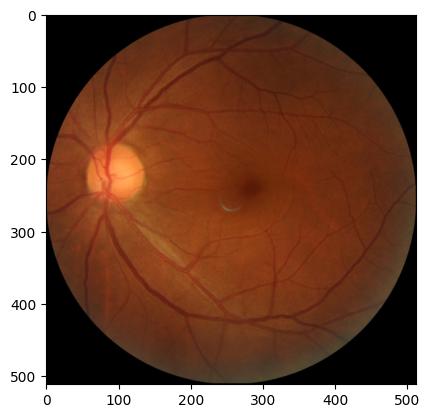

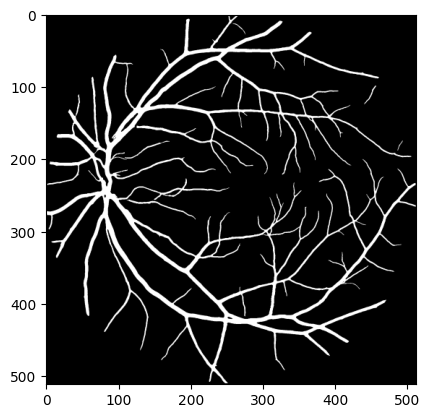

In [7]:
a=Image.open(images[9])
b=Image.open(masks[9])
# display the pair
plt.imshow(a,cmap='gray') 
plt.show()
plt.imshow(b,cmap='gray') # cmap=gray used to instruct Matplotlib to adher to images org pixel intensity , instead of deafult colormap ('virdis') to input as having a single channel for intensity mapping.
plt.show()

In [8]:
def load_split_dataset(samples,labels,train_ratio=0.8, val_ratio=0.195):
    # Shuffle before splitting
    combined = list(zip(samples, labels))
    random.shuffle(combined)
    samples[:], labels[:] = zip(*combined) # unzips

    total = len(samples)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_dataset = RBVD(samples[:train_end], labels[:train_end],train_flag=1)
    val_dataset = RBVD(samples[train_end:val_end], labels[train_end:val_end], train_flag=0)
    test_dataset = RBVD(samples[val_end:], labels[val_end:],train_flag=0)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_ds, val_ds , test_ds =  load_split_dataset(images,masks)

train_loader= DataLoader(train_ds,batch_size=6,shuffle=True,num_workers=4)
val_loader= DataLoader(val_ds,batch_size=6,shuffle=False , num_workers=4)
test_loader=DataLoader(test_ds,batch_size=6,shuffle=False , num_workers=4)

In [40]:
for x,y in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([6, 3, 256, 256]) torch.Size([6, 3, 256, 256])


# Model Development

In [11]:
# A Conv Block Instatntiation
class block_C2(nn.Module): # Conv[BN,LR]---> Conv[BN,LR]--->
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)
# Encode Instance
class encode(nn.Module):   # Maxpool2d(//2)--->block_C2(Conv[BN,LR]---> Conv[BN,LR])-->
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.down=nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            block_C2(in_channels,out_channels)
        )
    def forward(self,x):
        return self.down(x)
# Decode Instance
class decode(nn.Module):   # Reshape C--> C*2^2 -----> PixelShuffle(C,H*2,W*2)--->Concatenate (C_out---->2*C_out)---->Conv (C_out,H*2,W*2)---->
    def __init__(self,in_channels,out_channels):
        super().__init__()
        # Increase channel nos.
        self.pre_shuffle=nn.Conv2d(in_channels,out_channels*4,kernel_size=3,padding=1) # (C_in,H,W)---->(C_out*2^2,H,W)
        self.ps=nn.PixelShuffle(2) # Upsample by 2 times : (C_out,H*2,W*2)
        self.post_shuffle=block_C2(out_channels*2,out_channels) # after concatenation, it is currently out_channels*2----->out_channels 
    def forward(self,x_u,x_d):
        # Upsampled
        x_u=self.pre_shuffle(x_u)
        x_u=self.ps(x_u)
        # Skip Connection Implementation
        x_u=torch.cat([x_u,x_d],dim=1) #Concatenate encoder feature to decoder  feature at C(dim=1) in (B,C,H,W)
        x_u=self.post_shuffle(x_u) # Fix the channel count after concatenation for next stage upsampling.
        return x_u
# UNet Class
class UNetPlus(nn.Module):
    def __init__(self,n_channels=3,n_classes=1): # n_channels is the input no of channel and so is for the output. n_class=1 , as 1 param enough to handle two classes
        super().__init__()
        
        # Instantiate with channels as it is the default constructor
        self.entry_conv=block_C2(n_channels,64)  # (64,h,w)
        self.down1=encode(64,128) # (128,h//2, w//2)
        self.down2=encode(128,256) #  (256,h//4,w//4)
        self.down3=encode(256,512) # (512,h//8,w//8)
        self.down4=encode(512,1024) #  (1024,h//16,w//16)  ----->Maximal compression of feature map with Maximal channel counts. 
    # ------------------------------------------------- #
        self.up1=decode(1024,512) # (512,h//8,w//8)
        self.up2=decode(512,256) # (256,h//4,w//4)
        self.up3=decode(256,128) # (128,h//2,w//2)
        self.up4=decode(128,64) # (64,h,w)
    # ------------------------------------------------- #
        self.exit_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, n_channels, kernel_size=1),
        ) # (3,h,w)
        
    def forward(self,x):
        # Encoder
        x1=self.entry_conv(x) # (64,256,256)
        x2=self.down1(x1) # (128,128,128)
        x3=self.down2(x2) # (256,64,64)
        x4=self.down3(x3) # (512,32,32)
        x5=self.down4(x4) # (1024,16,16)
    # ------------------- #
        # Decoder
        x=self.up1(x5,x4) #(512,32,32)
        x=self.up2(x,x3) #(256,64,64)
        x=self.up3(x,x2) #(128,128,128)
        x=self.up4(x,x1) #(64,256,256)
    # ------------------- #
        # Last Layer
        x= self.exit_conv(x) # (3,256,256)  ----Sigmoid avoided , as used internally in BCEwithLogitsloss()
        
        return x


Initiate Model

In [12]:
device='cuda' if torch.cuda.is_available() else 'cpu'
model=UNetPlus().to(device)
print(device)

cuda


Dry Test

In [13]:
img_test=torch.randn(3,3,256,256).to(device)
output_test=model(img_test)
print(output_test.shape)

torch.Size([3, 3, 256, 256])


# Training 

In [14]:
# Dice Loss definition
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # logits -> probabilities
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

# Combined BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, smooth=1.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_loss = DiceLoss(smooth=smooth)
        
    def forward(self, pred, target):
        # BCE Loss (with logits)
        bce = F.binary_cross_entropy_with_logits(pred, target)
        
        # Dice Loss
        dice = self.dice_loss(pred, target)
        
        return self.bce_weight * bce + (1 - self.bce_weight) * dice

In [15]:
L=BCEDiceLoss()
y_test_tensor=torch.randn(3,3,256,256).to(device)
print(L(img_test,y_test_tensor))

tensor(0.9059, device='cuda:0')


# Metrics

In [18]:
from torchmetrics import(
JaccardIndex, #IoU
Accuracy, # Pixel Accuracy
Precision,
Recall,
F1Score
)
# Initialize metrics (all support binary/multi-class)
metrics = {
    'iou': JaccardIndex(task='binary', num_classes=2).to(device),       # IoU
    'pixel_acc': Accuracy(task='binary', num_classes=2).to(device),     # Pixel Accuracy
    'precision': Precision(task='binary', num_classes=2).to(device),
    'recall': Recall(task='binary', num_classes=2).to(device),
    'f1': F1Score(task='binary', num_classes=2).to(device)
}
def compute_metrics(pred, target, metric_dict):
    """Update and compute all metrics"""
    pred_sigmoid = torch.sigmoid(pred)
    pred_binary = (pred_sigmoid > 0.5).float()  # Threshold at 0.5
    
    results = {}
    for name, metric in metric_dict.items():
        metric.update(pred_binary, target.long())  # Target must be long() for TorchMetrics
        results[name] = metric.compute()
    return results

In [29]:
base_lr=.001
loss_fn=BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
epochs = 100
patience = 15
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
best_iou=0.0
best_f1=0.0

from collections import defaultdict

for epoch in range(epochs):
    # Reset metrics
    for metric in metrics.values():
        metric.reset()
    
    # Training Phase
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False)
    
    for batch_idx, (x, y) in enumerate(train_loader_tqdm):
        x = x.to(device)
        y_binary=(y > 0.5).float().to(device) # Force binary targets , else since during to tensor mask was in between [0,1].
        
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y_binary)
        loss.backward()
        optimizer.step()
        
        # Compute batch metrics (for display only)
        with torch.no_grad():
            pred_binary = (torch.sigmoid(pred) > 0.5).float()
            # y_binary = (y > 0.5).float()  
            batch_metrics = {}
            for name, metric in metrics.items():
                metric.update(pred_binary, y_binary)
                batch_metrics[name] = metric.compute().item()
                metric.reset()  # Reset after compute to avoid double-counting
        
        # Update tqdm every 2 batches
        if (batch_idx + 1) % 10 == 0:
            train_loader_tqdm.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'IoU': f"{batch_metrics['iou']:.4f}",
                'F1': f"{batch_metrics['f1']:.4f}",
                'Acc': f"{batch_metrics['pixel_acc']:.4f}"
            })
    metric.reset()
    # Validation Phase (unchanged)
    model.eval()
    val_results = defaultdict(float)
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            # Update metrics
            pred_binary = (torch.sigmoid(pred) > 0.5).float()
            y_binary = (y > 0.5).float()
            for metric in metrics.values():
                metric.update(pred_binary, y_binary)
    
    # Compute epoch-level metrics
    epoch_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    
    # Get validation metrics
    val_iou = metrics['iou'].compute().item()
    val_f1 = metrics['f1'].compute().item()
    
    # Print epoch summary
    if epoch%10 ==0:
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Loss: {loss.item():.4f} | IoU: {epoch_metrics['iou']:.4f} | F1: {epoch_metrics['f1']:.4f}")
        print(f"  Pixel Acc: {epoch_metrics['pixel_acc']:.4f}")
    
    if val_iou > best_iou or val_f1 > best_f1:
            best_iou = max(val_iou, best_iou)
            best_f1 = max(val_f1, best_f1)
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'RBVSeg_model.pt')
    else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                print(f"Best Val IoU: {best_iou:.4f} | Best Val F1: {best_f1:.4f}")
                break
        
        # Update scheduler
    scheduler.step(val_iou)  # Can also use val_f1


Epoch 0 Summary:
  Loss: 0.1094 | IoU: 0.7752 | F1: 0.8734
  Pixel Acc: 0.9809



Epoch 10 Summary:
  Loss: 0.1343 | IoU: 0.8074 | F1: 0.8935
  Pixel Acc: 0.9841



Epoch 20 Summary:
  Loss: 0.1329 | IoU: 0.8080 | F1: 0.8938
  Pixel Acc: 0.9840



Early stopping at epoch 26
Best Val IoU: 0.8090 | Best Val F1: 0.8944


# Testing

In [41]:
metric.reset()
for x, y in test_loader:
    x = x.to(device)
    y_binary=(y > 0.5).float().to(device)
    predicted = model(x)
    predicted=(torch.sigmoid(predicted)>.5).float()
    metric.update(predicted,y_binary)
test_results={name: metric.compute().item() for name, metric in metrics.items()}
print(test_results)    

{'iou': 0.8061148524284363, 'pixel_acc': 0.9838470220565796, 'precision': 0.8811537027359009, 'recall': 0.9044517278671265, 'f1': 0.8372639417648315}


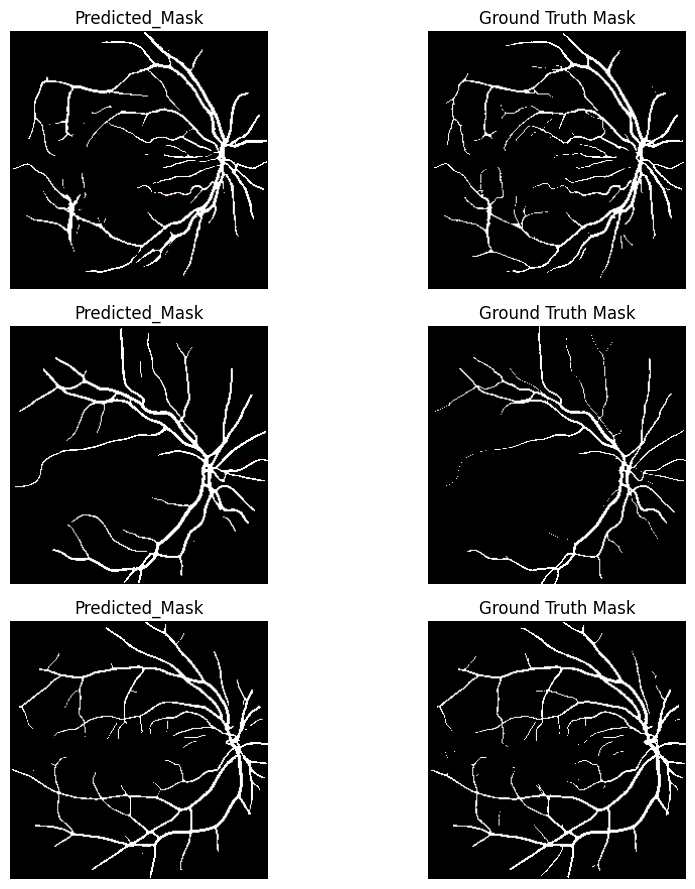

{'iou': 0.8061148524284363, 'pixel_acc': 0.9838470220565796, 'precision': 0.8811537027359009, 'recall': 0.9044517278671265, 'f1': 0.8372639417648315}


In [57]:
def plot_mask_pairs(test_loader, model, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y_binary = (y > 0.5).float().to(device)
            predicted = torch.sigmoid(model(x))
            predicted_binary = (predicted > 0.5).float()
            
            # Convert to numpy and make RGB
            y_np = y_binary.cpu().numpy()  # [B,3,H,W]
            pred_np = predicted_binary.cpu().numpy()  # [B,3,H,W]
            
            # Create figure
            fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images*3))
            
            for i in range(min(num_images, x.size(0))):
                # Prediction mask (convert to HWC format)
                axes[i,0].imshow(pred_np[i].transpose(1,2,0))
                axes[i,0].axis('off')
                axes[i,0].set_title('Predicted_Mask')
                
                # Ground Truth mask
                axes[i,1].imshow(y_np[i].transpose(1,2,0))
                axes[i,1].axis('off')
                axes[i,1].set_title('Ground Truth Mask')
            
            plt.tight_layout()
            plt.show()
            break
plot_mask_pairs(test_loader, model, device, num_images=3)
# Re Compute
metric.reset()
for x, y in test_loader:
    x = x.to(device)
    y_binary=(y > 0.5).float().to(device)
    predicted = model(x)
    predicted=(torch.sigmoid(predicted)>.5).float()
    metric.update(predicted,y_binary)
test_results={name: metric.compute().item() for name, metric in metrics.items()}
print(test_results) 